In [ ]:
#import os, sys
from google.colab import drive
drive.mount('/content/mnt')
#nb_path = '/content/notebooks'
#os.symlink('/content/mnt/My Drive/colabpackages', nb_path)
#sys.path.insert(0, nb_path)  # or append(nb_path)
#https://colab.research.google.com/drive/1KpMDi9CjImudrzXsyTDAuRjtbahzIVjq#scrollTo=trAxoCkMLgF1

In [ ]:
!pip install pyyaml==5.1
!pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install --target=$nb_path face-recognition

In [ ]:
# install dependencies: 
#!pip install pyyaml==5.1
#!pip install --target=$nb_path pyyaml==5.1

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
#opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")

#!pip install --target=$nb_path detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
#exit(0)

#!pip install --target=$nb_path requests~=2.23.0
#!pip install --target=$nb_path  grpcio
#!pip install --target=$nb_path  absl-py
#!pip install --target=$nb_path  jupyter-client
#!pip install --target=$nb_path  imgaug==0.2.7

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import IPython
from google.colab import output
from google.colab.patches import cv2_imshow

import time
import sys

from PIL import Image
from io import BytesIO
import base64
import logging
import numpy as np

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [156]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      //Shows the video
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // prints the logs to cell
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      for (let i = 0; i < 5; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // show each captured image
        //let imgTag = document.createElement('img');
        //imgTag.src = img;
        //div.appendChild(imgTag);

        //jsLog(i + "sending")
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.run_algo', [img], {});
        //jsLog(i + "SENT")

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));
      }
      stream.getVideoTracks()[0].stop(); // stop video stream
    }
    ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('takePhoto({})'.format(quality)) # call the takePhoto() JavaScript function

In [ ]:
def data_uri_to_img(uri):
  """convert base64image to numpy array"""
  try:
    image = base64.b64decode(uri.split(',')[1], validate=True)
    # make the binary image, a PIL image
    image = Image.open(BytesIO(image))
    # convert to numpy array
    image = np.array(image, dtype=np.uint8); 
    return image
  except Exception as e:
    logging.exception(e);print('\n')
    return None

In [ ]:
def run_algo(imgB64):
  """
  in Colab, run_algo function gets invoked by the JavaScript, that sends N images every second

  params:
    image: image
  """
  image = data_uri_to_img(imgB64)  
  if image is None:
    print("At run_algo(): image is None.")
    return

  try:
    outputs = predictor(image)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    #print(outputs["instances"].pred_classes)
    #print(outputs["instances"].pred_boxes)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

  except Exception as e:
    logging.exception(e)
    print('\n')

# register this function, so JS code could call this
output.register_callback('notebook.run_algo', run_algo)

<IPython.core.display.Javascript object>

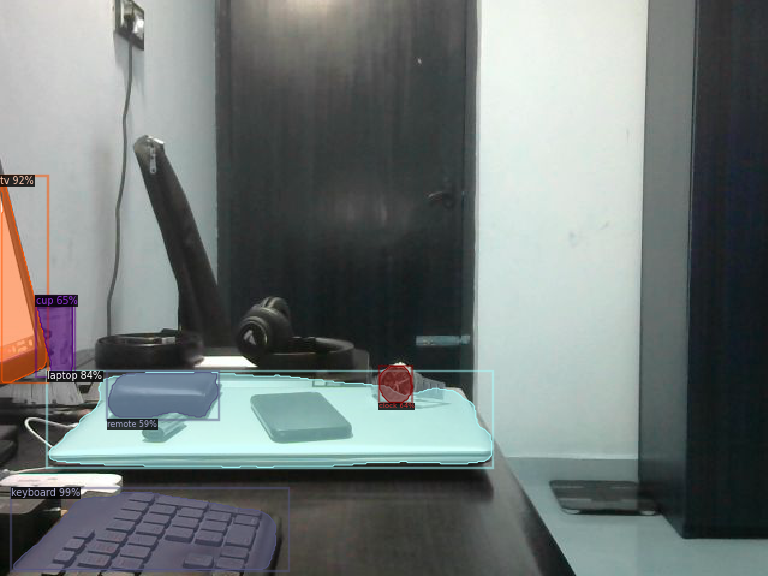

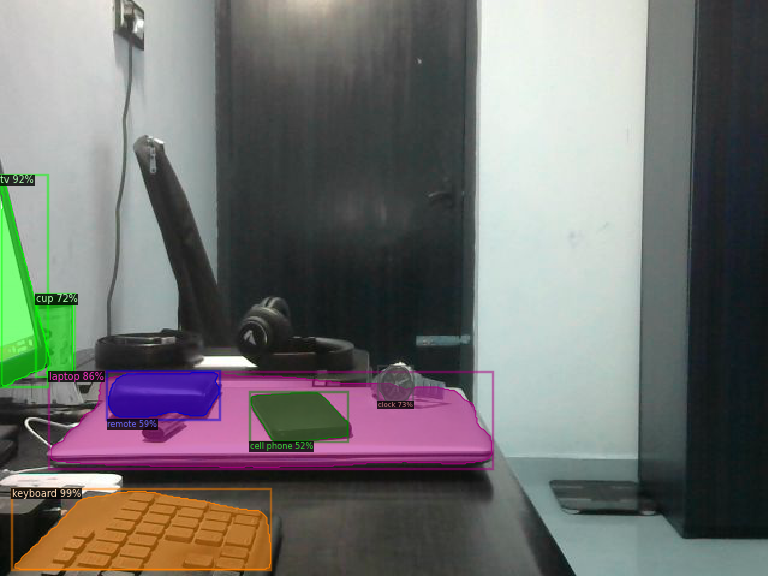

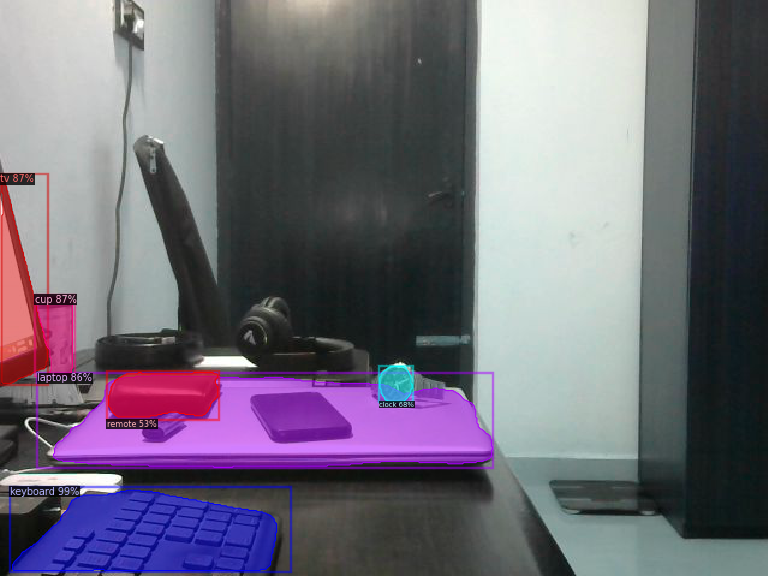

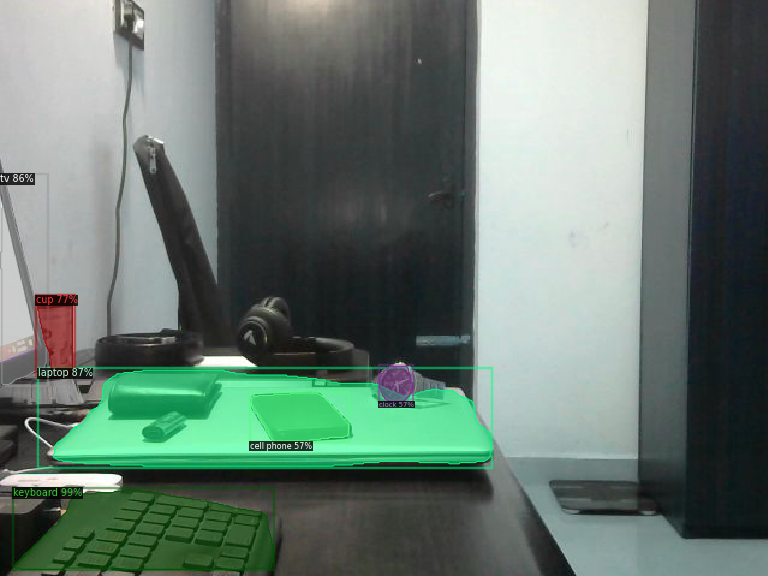

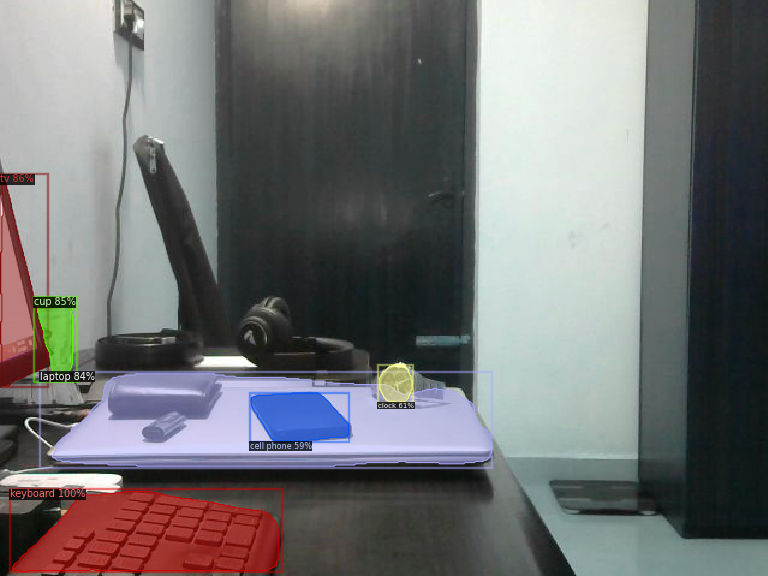

In [ ]:
# put the JS code in cell and run it
take_photo()

In [ ]:
#Facial Tagging module

In [ ]:
#!pip install --target=$nb_path face-recognition

In [ ]:
import face_recognition
import cv2
import numpy as np

In [ ]:
# Load a sample picture and learn how to recognize it.
prasad_image = face_recognition.load_image_file("/content/mnt/My Drive/colabpackages/prasad.jpg")
prasad_face_encoding = face_recognition.face_encodings(prasad_image)[0]

# Load a second sample picture and learn how to recognize it.
shanaya_image = face_recognition.load_image_file("/content/mnt/My Drive/colabpackages/shanaya.jpg")
shanaya_face_encoding = face_recognition.face_encodings(shanaya_image)[0]

# Create arrays of known face encodings and their names
known_face_encodings = [
   prasad_face_encoding,
   shanaya_face_encoding
]
known_face_names = [
    "Prasad",
    "Shanaya"
]

# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True

In [ ]:
'''
## Camera Capture
Using a webcam to capture images for processing on the runtime.
Source: https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi
'''
#process_this_frame = True

def stream_camera(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function streamCamera(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      //Shows the video
      //div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // prints the logs to cell
      let jsLog = function(abc) {
        document.querySelector("#output-area").appendChild(document.createTextNode(`${abc}... `));
      }

      // Wait for Capture to be clicked.
      // await new Promise((resolve) => capture.onclick = resolve);

      for (let i = 0; i < 3; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);

        // show each captured image
        //let imgTag = document.createElement('img');
        //imgTag.src = img;
        //div.appendChild(imgTag);

        //jsLog(i + "sending")
        // Call a python function and send this image
        google.colab.kernel.invokeFunction('notebook.face_algo', [img], {});
        //jsLog(i + "SENT")

        // wait for X miliseconds second, before next capture
        await new Promise(resolve => setTimeout(resolve, 250));
      }
      
      stream.getVideoTracks()[0].stop(); // stop video stream
    }
    ''')
  display(js) # make the provided HTML, part of the cell
  data = eval_js('streamCamera({})'.format(quality)) # call the streamCamera() JavaScript function

In [ ]:
def face_algo(imgB64):
  frame = data_uri_to_img(imgB64) 
  
  if frame is None:
    print("At face_algo(): image is None.")
    return
  try:
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = small_frame[:, :, ::-1]
    # Only process every other frame of video to save time
    #if process_this_frame:
    # Find all the faces and face encodings in the current frame of video
    face_locations = face_recognition.face_locations(rgb_small_frame)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
    face_names = []

    for face_encoding in face_encodings:
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = "Unknown"

        # # If a match was found in known_face_encodings, just use the first one.
        # if True in matches:
        #     first_match_index = matches.index(True)
        #     name = known_face_names[first_match_index]

        # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        face_names.append(name)

    #process_this_frame = not process_this_frame

    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
        # Scale back up face locations since the frame we detected in was scaled to 1/4 size
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        # Blue color in BGR 
        color = (255, 0, 0) 
        # Line thickness of 2 px 
        thickness = 2

        # Draw a box around the face
        cv2.rectangle(frame, (left, top), (right, bottom), (0,128,0), thickness)
     
        # Draw a label with a name below the face
        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), color, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

    # Display the resulting image  
    cv2_imshow(frame)

  except Exception as e:
    logging.exception(e)
    print('\n')
  
# register this function, so JS code could call this
output.register_callback('notebook.face_algo', face_algo)

<IPython.core.display.Javascript object>

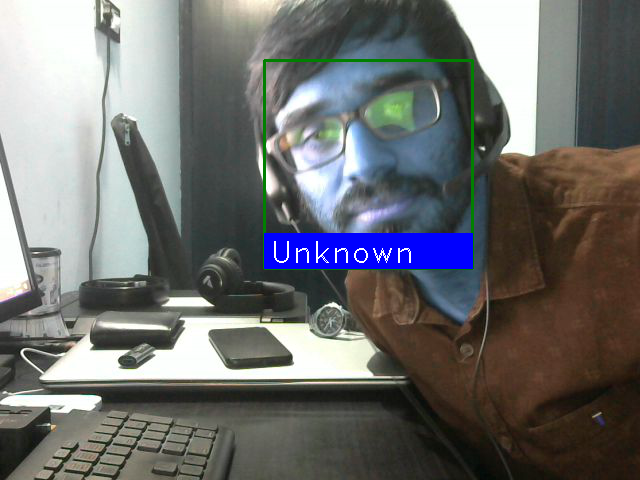

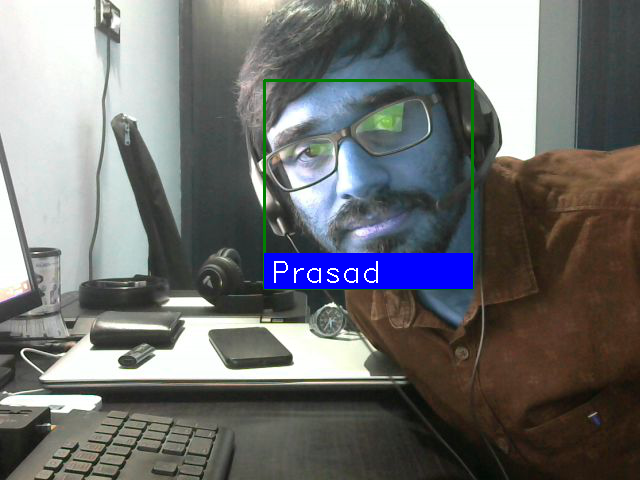

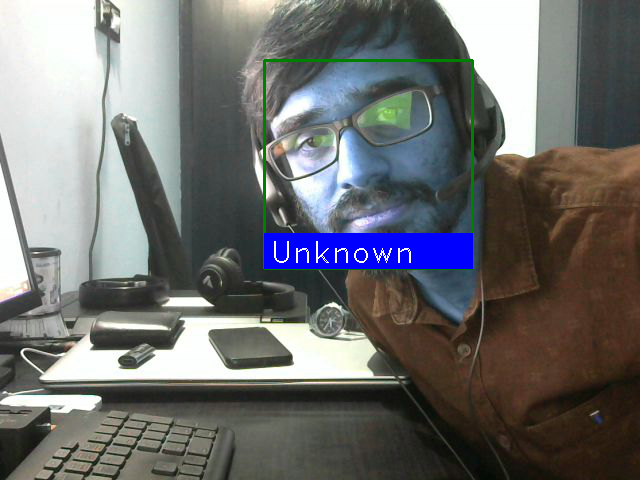

In [ ]:
# put the JS code in cell and run it
stream_camera()